# Illicit transaction model results
# Interpretation of model
https://www.kaggle.com/datasets/ellipticco/elliptic-data-set/data

[1] Elliptic, www.elliptic.co.

[2] M. Weber, G. Domeniconi, J. Chen, D. K. I. Weidele, C. Bellei, T. Robinson, C. E. Leiserson, "Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics", KDD ’19 Workshop on Anomaly Detection in Finance, August 2019, Anchorage, AK, USA.

Description: The Elliptic Data Set maps Bitcoin transactions to real entities belonging to licit categories (exchanges, wallet providers, miners, licit services, etc.) versus illicit ones (scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc.). The task on the dataset is to classify the illicit and licit nodes in the graph.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
# Modeling tools
from src.models.evaluate_model import *
from src.models.train_model import * 

# SHAP for interpretability
import shap

# Set random seeds for reproducibility
import random
import torch
random.seed('ROSALIA')
np.random.seed(3)
torch.manual_seed(15)
final_threshold = 0.90261316

In [2]:
with open('models/isolation_forest.pkl', 'rb') as f:
    loaded_iso_forest = pickle.load(f)


loaded_xgb_model = xgb.Booster()
loaded_xgb_model.load_model('models/xgboost_model.json')

with open('models/model_config.pkl', 'rb') as f:
    config = pickle.load(f)

# Use the loaded models for prediction
new_transactions = pd.read_parquet('data/processed/df_model.parquet')
# Define features
augmented_net_feat = [c for c in new_transactions.columns if c.startswith('gw_') or c.startswith('gcn_')]
features = augmented_net_feat + [c for c in new_transactions.columns if c.startswith('neighbors_') or c.startswith('transaction_')]
X = new_transactions.loc[:, features]
Y = new_transactions['class_label']

# Split into labeled and unlabeled
X_all_labeled = X[Y != 'unknown'].copy()
y_all_labeled = Y[Y != 'unknown'].map({'licit': 0, 'illicit': 1})
X_unlabeled = X[Y == 'unknown'].copy()

# Create a stratified split of labeled data: train (60%), validation (20%), test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_all_labeled, y_all_labeled, test_size=0.2, random_state=42, stratify=y_all_labeled
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)


predictions, metadata, X_train_with_scores = prediction_pipeline(
    X_train,
    loaded_iso_forest,
    loaded_xgb_model,
    config['threshold']
)

predictions, metadata, X_test_with_scores = prediction_pipeline(
    X_test,
    loaded_iso_forest,
    loaded_xgb_model,
    config['threshold']
)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s



=== MODEL INTERPRETABILITY WITH SHAP ===


/var/folders/bq/l2cp2f_s13xggz6c1njx5f_40000gn/T/ipykernel_16356/1267668327.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, shap_sample, plot_type="bar", show=False)


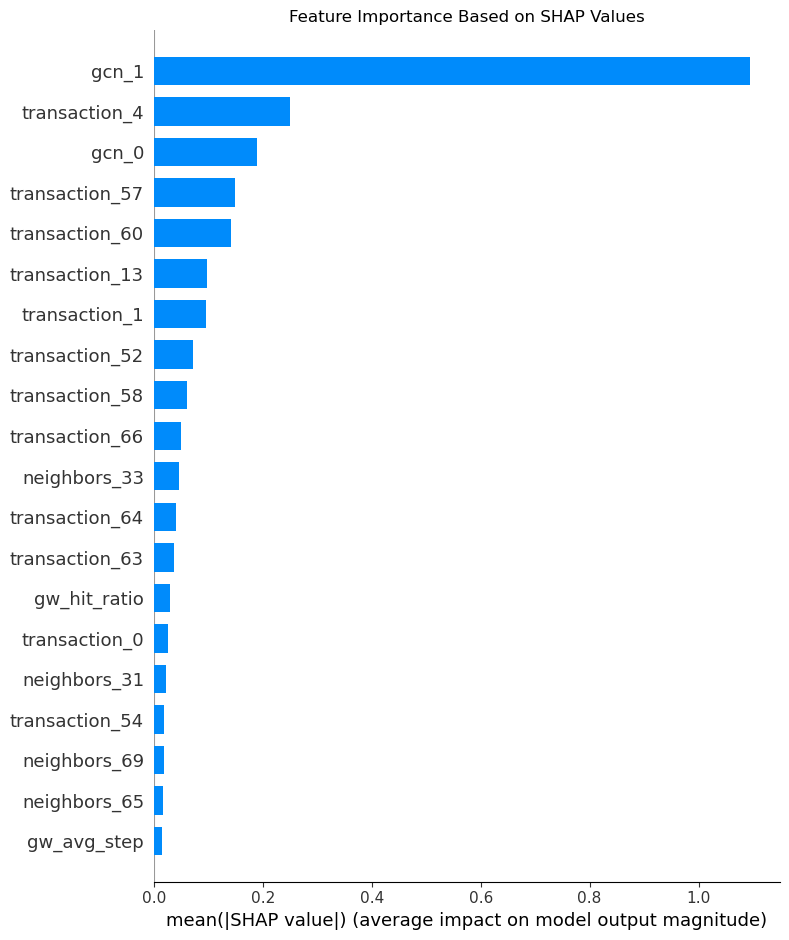

<Figure size 1000x600 with 0 Axes>

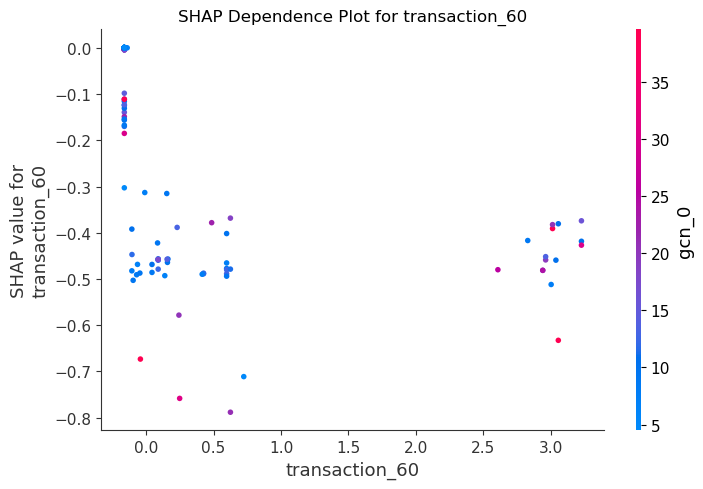

<Figure size 1000x600 with 0 Axes>

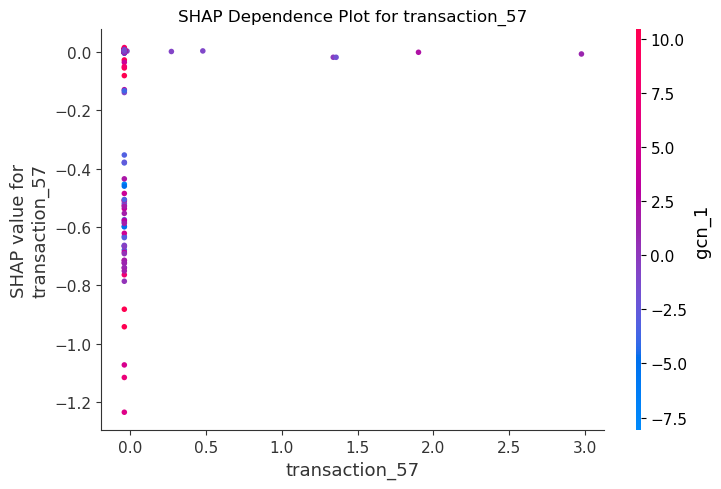

<Figure size 1000x600 with 0 Axes>

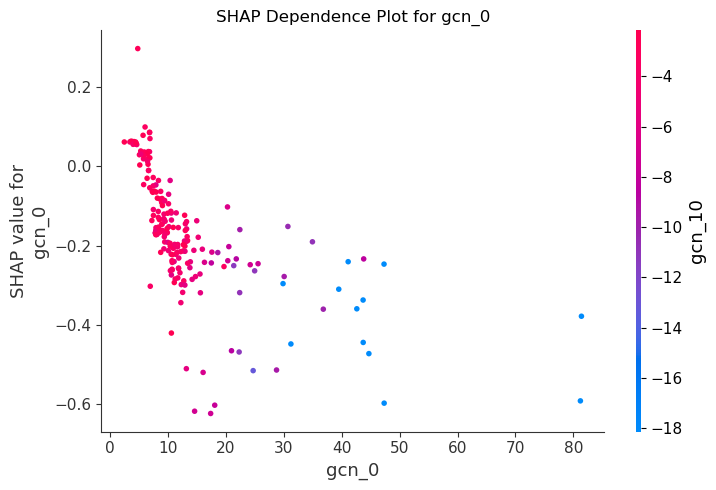

<Figure size 1000x600 with 0 Axes>

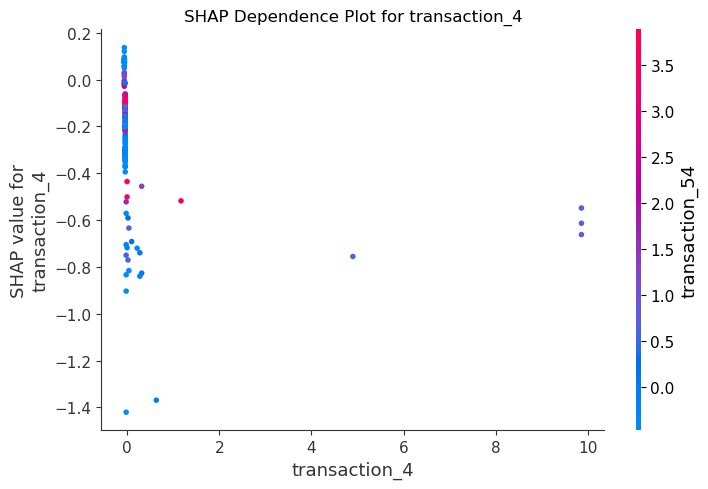

<Figure size 1000x600 with 0 Axes>

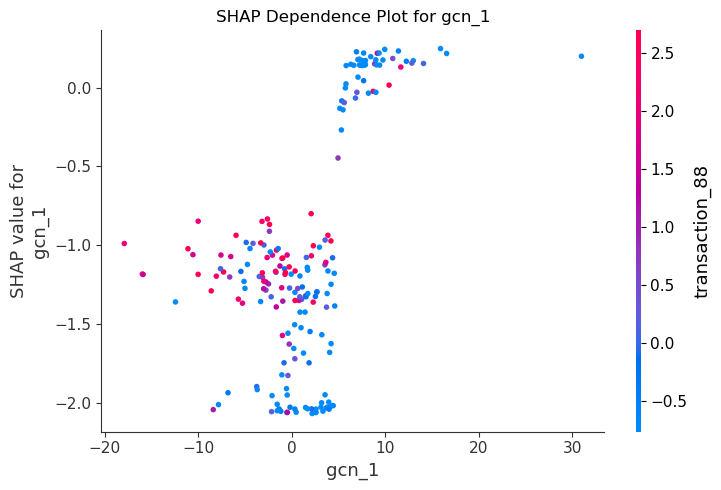


Sample Transaction Explanation:
Prediction: licit (probability: 0.3833)
Top Contributing Features:
  gcn_1: -1.8335 (DECREASES probability of being illicit)
  gcn_0: -0.2824 (DECREASES probability of being illicit)
  transaction_52: -0.2715 (DECREASES probability of being illicit)
  transaction_4: -0.1480 (DECREASES probability of being illicit)
  neighbors_65: -0.0862 (DECREASES probability of being illicit)


In [3]:
# Step 5: Model Interpretability with SHAP
# Create a background dataset for SHAP
background_data = X_train_with_scores.sample(min(1000, len(X_train_with_scores)), random_state=42)
dbackground = xgb.DMatrix(background_data)

# Initialize SHAP explainer
explainer = shap.TreeExplainer(loaded_xgb_model)

# Calculate SHAP values for a sample of test data
shap_sample = X_test_with_scores.sample(min(200, len(X_test_with_scores)), random_state=42)
shap_values = explainer.shap_values(shap_sample)

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, shap_sample, plot_type="bar", show=False)
plt.title("Feature Importance Based on SHAP Values")
plt.tight_layout()
plt.show()

# Plot SHAP dependency plots for top features
top_features = np.argsort(np.abs(shap_values).mean(0))[-5:]  # Top 5 features
for feature in top_features:
    feature_name = shap_sample.columns[feature]
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values, shap_sample, show=False)
    plt.title(f"SHAP Dependence Plot for {feature_name}")
    plt.tight_layout()
    plt.show()
    
# Demonstrate explanation for a sample transaction
sample_transaction = X_test_with_scores.iloc[0]
explanation = explain_prediction(sample_transaction, loaded_xgb_model, explainer, final_threshold)
print("\nSample Transaction Explanation:")
print(f"Prediction: {explanation['prediction']} (probability: {explanation['probability']:.4f})")
print("Top Contributing Features:")
for feature, value in explanation['top_features']:
    direction = "INCREASES" if value > 0 else "DECREASES"
    print(f"  {feature}: {value:.4f} ({direction} probability of being illicit)")


In [4]:
# Test the pipeline on unlabeled data
print("\nRunning prediction pipeline on unlabeled data...")
predictions, metadata, new_data_with_scores = prediction_pipeline(
    X_unlabeled, 
    loaded_iso_forest, 
    loaded_xgb_model, 
    final_threshold,
    explainer=explainer
)

print(f"Processed {metadata['total_transactions']} transactions in {metadata['processing_time_seconds']:.2f} seconds")
print(f"Processing speed: {metadata['transactions_per_second']:.2f} transactions per second")
print(f"Flagged {metadata['illicit_predictions']} transactions as potentially illicit")
print(f"That's {metadata['illicit_predictions']/metadata['total_transactions']*100:.2f}% of transactions")




Running prediction pipeline on unlabeled data...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


Processed 157205 transactions in 1.24 seconds
Processing speed: 127094.02 transactions per second
Flagged 10186 transactions as potentially illicit
That's 6.48% of transactions



=== FEATURE IMPORTANCE ANALYSIS ===


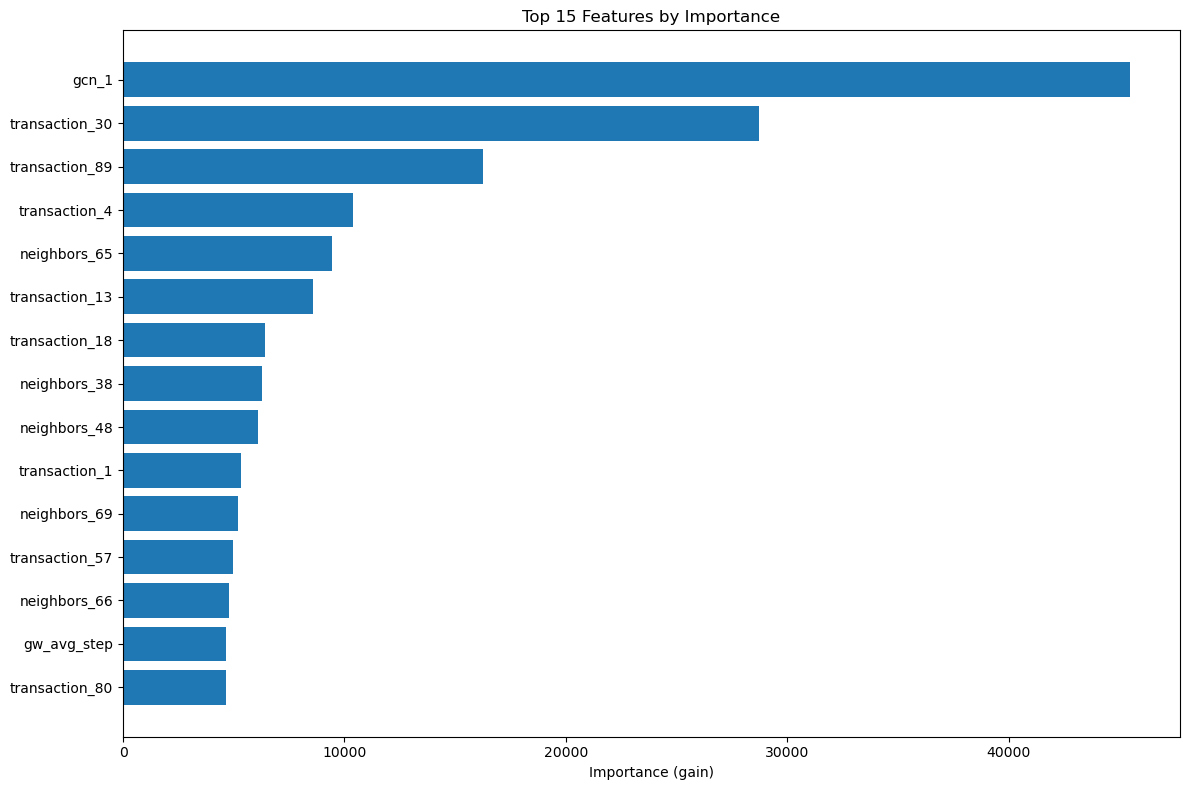

/var/folders/bq/l2cp2f_s13xggz6c1njx5f_40000gn/T/ipykernel_16356/312934713.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, shap_sample, show=False)


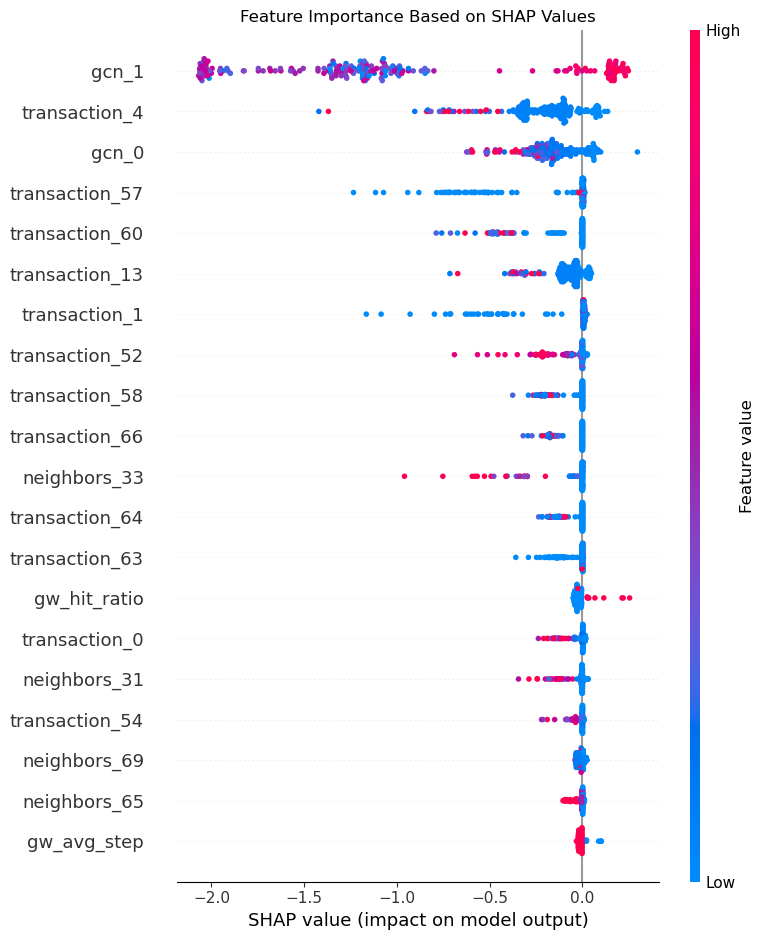

In [5]:

# === FEATURE IMPORTANCE AND MODEL INSIGHTS ===
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature importance from XGBoost
feature_importance = loaded_xgb_model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})
importance_df = importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['feature'][:15], importance_df['importance'][:15])
plt.xlabel('Importance (gain)')
plt.title('Top 15 Features by Importance')
plt.gca().invert_yaxis()  # Display most important at the top
plt.tight_layout()
plt.show()

# Compare with SHAP importance
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, shap_sample, show=False)
plt.title("Feature Importance Based on SHAP Values")
plt.tight_layout()
plt.show()


We have found that in order of feature importance based on SHAP values the original transaction variables are very important for model classification. As they are anonimized, we can only wonder they're meaning but they give us direction on the type of information to collect. 

There were two embedding variables who where in the top 3, which give us insight into the importance of the graph structure and the hidden relationships between the nodes. More analysis must be done in extracting value from the network from other types of models more advanced.

* For gcn_1, the highest values had more probability of being illicit.
* For transaction_4, the highest values had less probability of being illicit. 

According to SHAP values the most important interactions between variables where transaction_60 and gcn_0; transaction_57 and gcn_1; gcn_0 and gcn_10 and gcn_1 and transaction_88. This can help compliance investigators in understanding the relationships hidden between different types of variables (and information)
